# Project 2 - Deep Hedging : multi-asset case
## Deep Learning in Finance

**Ahmad Alae - Bout Nathan - Boyenval Thibaut**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add

from keras.models import Model
from keras import initializers
import keras.backend as K_backend

Let us recall here the main elements of the problem, in the case of two assets with values $S^1$ and $S^2$.

+ Delta-hedge of an option $g(S^1_T, S^2_T)$ on a time grid $t_j = j \, \frac T N = j$.

+ The hedging portfolio with delta-hedging strategy $\delta^1_t$, $\delta^2_t$  evolves in time as

$$
V_{t_{j+1}}
= V_{t_j} + r (V_{t_j} - \delta^1_{t_j} S^1_{t_j} - \delta^2_{t_j} S^2_{t_j}) \Delta t + \delta^1_{t_j} (S^1_{t_{j+1}} - S^1_{t_j}) + \delta^2_{t_j} (S^2_{t_{j+1}} - S^2_{t_j}),
\qquad j = 0, \dots, N-1
$$

Therefore, the final portfolio value is

$$
V_T = V_{t_N} = \pi_0 + \sum_{j=0}^{N-1} \bigl( r (V_{t_j} - \delta^1_{t_j} S^1_{t_j} - \delta^2_{t_j} S^2_{t_j}) \Delta t + \delta^1_{t_j} (S^1_{t_{j+1}} - S^1_{t_j}) + \delta^2_{t_j} (S^2_{t_{j+1}} - S^2_{t_j}) \bigr)
$$

where $V_0 = \pi_0$ is the initial option price (or premium).

+ The model for the underlying assets dynamics has Gaussian log-returns

$$
\log S^i_{t_{j+1}} = \log S^i_{t_j} + \mu_i \Delta t + \sigma_i \sqrt{\Delta t} \, G^i_j
$$

where is $(G^i_j)_{j \ge 1}$ a sequence of independent gaussian vectors.

We generate a training set of of $N_{\mathrm{train}}$ asset price trajectories $\Bigl( S^i_{t_j} \Bigr)_{0 \le j \le N}^{1 \le i \le N_{\mathrm{train}}}$ according to the model above for each asset.

+ _Deep hedging_: the hedging strategy is parameterized by a neural network $h_{\theta_j}$ at each time point $t_j$

$$
(\delta^1_{t_j}, \delta^2_{t_j}) = h_{\theta_j} (S^1_{t_j}, S^2_{t_j}), \qquad j = 0, \dots, N-1
$$

and the option premium as well: $\pi_0 = \pi_\theta(S^1_0, S^2_0)$.

### Question 1

We construct a training set of $N\_train$ two-dimensional trajectories $(S^1_{t_j}, S^2_{t_j})$

For the two assets we use the log-normal dynamical model. This require to simulate a sequence of i.i.d. Gaussian vectors $(G_{1_j}, G_{2_j})$ with correlation parameter $\rho$.

In [2]:
def G(N, rho):
    mean = np.zeros(2)
    covariance_matrix = np.array([[1, rho], [rho, 1]])
    gaussian_vectors = np.random.multivariate_normal(mean, covariance_matrix, N)
    return gaussian_vectors

def generate_log_increments(N_train, N, T, mu1, mu2, sigma1, sigma2, rho):
    dt = T / N  # Time step
    log_increments = []
    for i in range(N_train):
        log_increment = np.zeros((N, 2))
        Z = G(N, rho)
        for j in range(N):
            log_increment[j, 0] = mu1 * dt + sigma1 * np.sqrt(dt) * Z[j, 0]
            log_increment[j, 1] = mu2 * dt + sigma2 * np.sqrt(dt) * Z[j, 1]
        log_increments.append(log_increment)
    return np.array(log_increments)

def generate_trajectory(S01, S02, N, log_increment):

    S1 = np.zeros(N+1)
    S2 = np.zeros(N+1)
    
    # Setting initial asset prices
    S1[0] = S01  # Assuming you have an initial price S01
    S2[0] = S02  # Assuming you have an initial price S02
    
    for j in range(N):
        S1[j+1] = S1[j] * np.exp(log_increment[j, 0])
        S2[j+1] = S2[j] * np.exp(log_increment[j, 1])
    
    return S1, S2

def generate_trajectories( N_train, S01 = 1, S02 = 1, N = 100, T=1, mu1=0.025, mu2=-0.01, sigma1=0.22, sigma2=0.3, rho=0.5):
    trajectories = []
    log_increments = generate_log_increments(N_train, N, T, mu1, mu2, sigma1, sigma2, rho)
    for i in range(N_train):
        S1, S2 = generate_trajectory(S01, S02, N, log_increments[i])
        trajectories.append((S1, S2))
    return log_increments, np.array(trajectories)


Let us define parameters for the training set.

In [3]:
N = 100
T=1
mu1=0.025
mu2=-0.01
sigma1=0.22
sigma2=0.3
rho=0.5
S0= np.array([1, 1])

r=0.04
strike = 1
Delta_T = T/N

N_train = 10**5
log_increments, trajectories = generate_trajectories(N_train, S01 = S0[0], S02 = S0[1], N=N, T=T, mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2, rho=rho)

Let us plot a batch of trajectories coming from the training set:

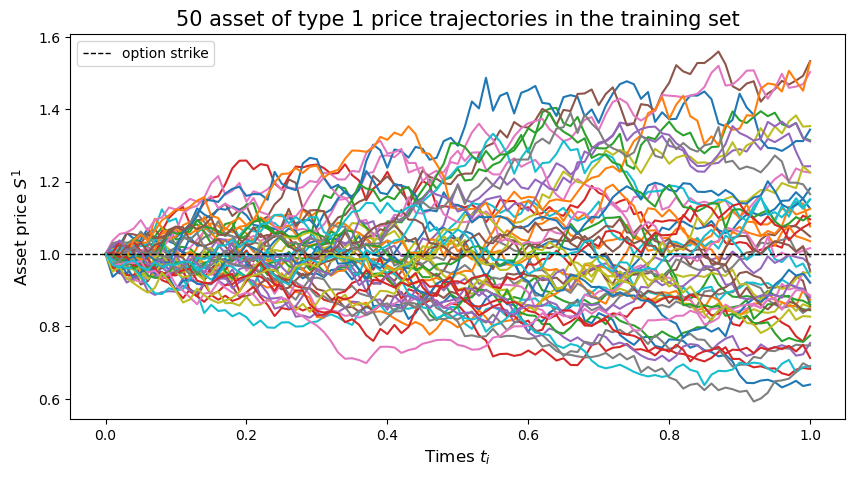

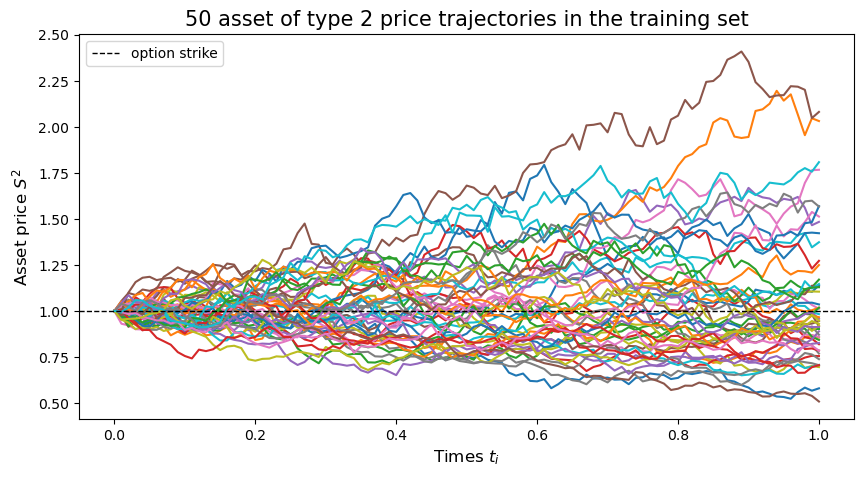

In [4]:
M = 50
grid = np.linspace(0, T, N+1)

traject_to_plot = trajectories[:M, 0, :].T

plt.figure(figsize=(10,5))
plt.plot(grid, traject_to_plot)
plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="option strike")

plt.title("%1.0f asset of type 1 price trajectories in the training set" %M, fontsize=15)
plt.xlabel("Times $t_i$", fontsize=12)
plt.ylabel("Asset price $S^1$", fontsize=12)
plt.legend(loc="best")
plt.show()

traject_to_plot = trajectories[:M, 1, :].T

plt.figure(figsize=(10,5))
plt.plot(grid, traject_to_plot)
plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="option strike")

plt.title("%1.0f asset of type 2 price trajectories in the training set" %M, fontsize=15)
plt.xlabel("Times $t_i$", fontsize=12)
plt.ylabel("Asset price $S^2$", fontsize=12)
plt.legend(loc="best")
plt.show()

### Question 2

We define here the architecture of our neural network. We use a similar architecture to the one created during the tutorial. However, we replace the value of m by 2 and modify the payoff to adapt to the multi-asset case.

In [5]:
def model1(N, m, d, n):
    layers = []
    for j in range(N):
        for i in range(d):
            if i < d-1:
                nodes = n
                layer = Dense(units = nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1), #kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
            else:
                nodes = m
                layer = Dense(units = nodes, activation='linear', trainable=True,
                              kernel_initializer=initializers.RandomNormal(0,0.1), #kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(i)+str(j))
            layers = layers + [layer]
    return layers


In [6]:
m = 2
d = 3
n = 32
layers = model1(N, m, d, n)

In [7]:
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedge_eval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedge_eval]+[premium]
output_helper = []

premium = Dense(units = 1, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

hedge = premium

for j in range(N):
    strategy = price
    strategy_eval = hedge_eval

    for k in range(d):
        strategy = layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at time t_j, i.e. the neural network h_j
        strategy_eval = layers[k+(j)*d](strategy_eval)

    incr = Input(shape=(m,)) # input variable: the single log-increment between t_j and t_{j+1} (dimension = m)
    inputs = inputs + [incr]
    
    # The instruction Lambda(lambda x : g(x)) wraps the function lambda into a layer object
    # Similarly, the instructions Add(), Subtract(), and Multiply() apply binary operations to layer objects
    logprice = Lambda(lambda x : K_backend.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : K_backend.exp(x))(logprice) # creating the price at time j+1 by exponentiation
    priceincr = Subtract()([pricenew, price]) # the asset price increment S_{j+1} - S_j

    # Hedging portfolio
    delta_part = Multiply()([strategy, price])
    cash_part = Subtract()([hedge, delta_part])

    cash_part_new = Multiply()([cash_part, np.array([r*Delta_T,]) ])
    delta_part_new = Multiply()([strategy, priceincr])

    hedgenew = Add()([cash_part_new, delta_part_new])
    hedge = Add()([hedge, hedgenew]) # building up the hedging portfolio

    output_helper = output_helper + [strategy_eval]
    price = pricenew

payoff = Lambda( lambda x : (K_backend.maximum(x[:,0]*x[:,1]-strike, 0)) )(price)
outputs = Subtract()([payoff, hedge]) # payoff minus the hedging portfolio (the option premium is already included in the variable 'hedge')

# This is the point where we construct the model output :
# hedging error + hedging strategy evaluated over the chosen points in the training set + option premium
outputs = [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

#################################################################
# Note that our model contains all the different neural networks that
# implement the delta hedging strategy at the different times t_j
#################################################################
model_hedge_strat = Model(inputs=inputs, outputs=outputs)


In [8]:
def custom_loss(y_true, y_pred):
    z = y_pred[:, 0] - y_true[:, 0]
    z = K_backend.mean(K_backend.square(z))
    return z

In [9]:
model_hedge_strat.compile(optimizer='adam', loss=custom_loss)

In [10]:
xtrain = ([S0 * np.ones((N_train, m))]  # asset price: same S_0 for all the trajectories
          + [np.zeros((N_train, m))]  # initial delta portion of the portfolio
          + [S0 * np.ones((N_train, m))]  # points over which the model can evaluate and output the hegding strategy (for plotting purposes)
          + [np.zeros((N_train, m))]  # input value for the option premium for each asset trajectory
          + list(np.transpose(log_increments, (1, 0, 2))))
ytrain = np.zeros((N_train, 1))

In the cell below, we launch the model training, limiting ourselves to 5 epochs.

In [11]:
model_hedge_strat.fit(x=xtrain, y=ytrain, epochs=5, verbose=True, batch_size=100)

Epoch 1/5
1000/1000 [==============================] - 91s 54ms/step - loss: 0.0791
Epoch 2/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.0652
Epoch 3/5
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0630
Epoch 4/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.0624
Epoch 5/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.0621


### Question 3

Let us evaluate the performance of the deep model: we display the histogram of the hedging error over the training set.
Recall that :

hedging error = payoff - (delta hedge + option premium).

In [12]:
model_output = model_hedge_strat.predict(xtrain)

3125/3125 [==============================] - 52s 15ms/step


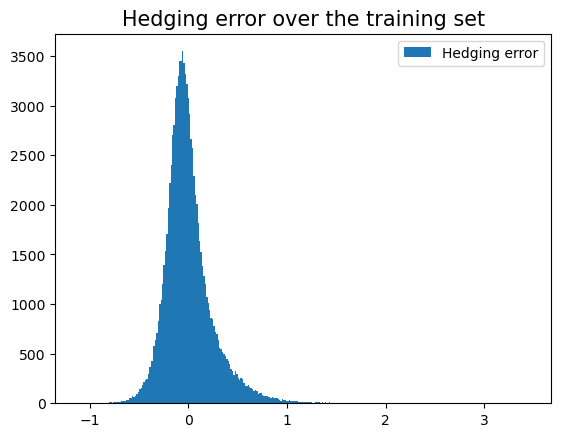

Hedging error sample average: 3.021e-03
Hedging error standard deviation: 2.478e-01 
 
Average option premium over the training set: 0.2345


In [13]:
# Hedging error = payoff minus delta hedge minus option premium = the first variable in the model output
hedging_error = model_output[:, 0]
plt.hist(hedging_error, bins=int(np.sqrt(N_train)), label="Hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("Hedging error sample average: %1.3e" %np.mean(hedging_error))
print("Hedging error standard deviation: %1.3e \n " %np.std(hedging_error))

# Option price we obtained from the training = the last variable in the model output
output_option_premium = model_output[:, -1]

print("Average option premium over the training set: %1.4f" %np.mean(output_option_premium))

Then, we can display the model delta hedge (that is, the hedging strategy predicted by the deep model) for each asset.

In [14]:
N_test = 100

# points over which the model output evaluates the hedging strategy
hedge_eval_grid = np.ones((N_test, m))
hedge_eval_grid[:, 0] = np.linspace(0.5, 1.5, N_test)
hedge_eval_grid[:, 1] = np.linspace(0.5, 1.5, N_test)

log_increments_test, trajectories_test = generate_trajectories(N_test, S01 = S0[0], S02 = S0[1], N=N, T=T, mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2, rho=rho)

print(np.shape(list(np.transpose(log_increments_test, (1, 0, 2)))))
xtest = ([S0 * np.ones((N_test, m))]
          + [np.zeros((N_test, m))]  # initial values for the delta hedging part
          + [hedge_eval_grid]
          + [np.zeros((N_test, m))] # input value for the option premium
          + list(np.transpose(log_increments_test, (1, 0, 2))))



(100, 100, 2)


In [15]:
print(np.shape(model_hedge_strat.predict(xtest)))

4/4 [==============================] - 4s 29ms/step
(100, 203)


4/4 [==============================] - 0s 26ms/step


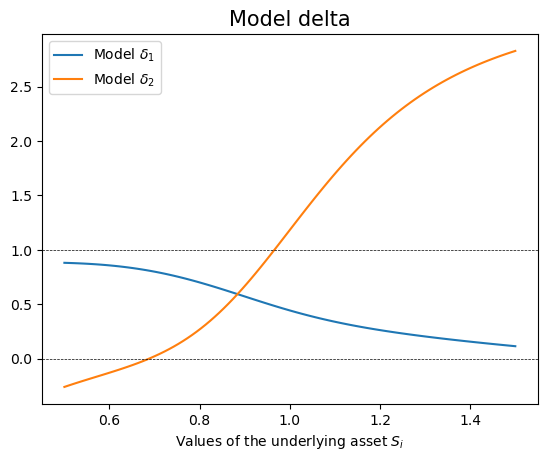

In [16]:
# Let us choose a point on the grid of N time points t_j
l = 90

# The model delta
model_delta = model_hedge_strat.predict(xtest)[:,l+3:l+5]

plt.plot(hedge_eval_grid[:,0], model_delta[:,0], label="Model $\delta_1$")
plt.plot(hedge_eval_grid[:,1], model_delta[:,1], label="Model $\delta_2$")

plt.axhline(0, linestyle="--", linewidth=0.5, color="k")
plt.axhline(1, linestyle="--", linewidth=0.5, color="k")

plt.xlabel("Values of the underlying asset $S_i$")
plt.title("Model delta", fontsize=15)
plt.legend(loc="best")
plt.show()